In [13]:
using Pkg
Pkg.activate("/home/molloi-lab/Desktop/Project BAC/BAC project/libs/")
using Lux, NNlib, Zygote, LuxCUDA, CUDA, JLD2, DICOM
using Images
using MLUtils
using Optimisers, ProgressBars
using ImageMorphology, ChainRulesCore, Statistics

CUDA.allowscalar(false)

valid_data_dir = "/home/molloi-lab/Desktop/Project BAC/collected_dataset_for_ML/valid"
saved_model_dir = "/home/molloi-lab/Desktop/Project BAC/BAC project"
patch_size = 256
patch_size_half = round(Int, patch_size/2);

  Activating project at `~/Desktop/Project BAC/BAC project/libs`


# Helper functions

In [50]:
_conv = (in, out) -> Conv((3, 3), in=>out, pad=1)

conv1 = (in, out) -> Chain(_conv(in, out), BatchNorm(out, leakyrelu))
# conv2 = (in, out) -> Chain(_conv(in, out), x -> softmax(x; dims = 3))
conv2 = (in, out) -> Chain(Conv((1, 1), in=>out), sigmoid)

_tran = (in, out) -> ConvTranspose((2, 2), in => out, stride = 2)
tran = (in, out) -> Chain(_tran(in, out), BatchNorm(out, leakyrelu))

my_cat = (x, y) -> cat(x, y; dims=Val(3))

function unet2D(in_chs, lbl_chs)    
    # Contracting layers
    l1 = Chain(conv1(in_chs, 64), conv1(64, 64))
    l2 = Chain(l1, MaxPool((2,2), stride=2), conv1(64, 128), conv1(128, 128))
    l3 = Chain(l2, MaxPool((2,2), stride=2), conv1(128, 256), conv1(256, 256))
    l4 = Chain(l3, MaxPool((2,2), stride=2), conv1(256, 512), conv1(512, 512))
    l5 = Chain(l4, MaxPool((2,2), stride=2), conv1(512, 1024), conv1(1024, 1024), tran(1024, 512))
    
    # Expanding layers
    l6 = Chain(Parallel(my_cat,l5,l4), conv1(512+512, 512), conv1(512, 512), tran(512, 256))
    l7 = Chain(Parallel(my_cat,l6,l3), conv1(256+256, 256), conv1(256, 256), tran(256, 128))
    l8 = Chain(Parallel(my_cat,l7,l2), conv1(128+128, 128), conv1(128, 128), tran(128, 64))
    l9 = Chain(Parallel(my_cat,l8,l1), conv1(64+64, 64), conv1(64, 64), conv2(64, lbl_chs))
end

function zoom_pxiel_values(img)
    a, b = minimum(img), maximum(img)
    img_ = (img .- a) ./ (b - a)
    return img_
end

function normalize_img(img)
    m = maximum(img)
    img = m .- img
    a = mean(img)
    s = std(img)
    img = (img .- a) ./ s 
    # println("mean = $(mean(img)), std = $(std(img))")
    return img
end

function get_num_of_forgound_patches(mask, s)
    x = ceil(Int, s[1]/patch_size) + floor(Int, (s[1]-patch_size_half)/patch_size)
    y = ceil(Int, s[2]/patch_size) + floor(Int, (s[2]-patch_size_half)/patch_size)
    ct = 0
    for i = 1 : x-1
        x_start = 1+(i-1)*patch_size_half
        x_end = x_start+patch_size-1
        for j = 1 : y-1
            y_start = 1+(j-1)*patch_size_half
            y_end = y_start+patch_size-1
            # check patch
            if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
                ct += 1
            end
        end
        # right col
        y_start, y_end = s[2]-patch_size+1, s[2]
        # check patch
        if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
            ct += 1
        end
    end
    # last row
    x_start, x_end = s[1]-patch_size+1, s[1]
    for j = 1 : y-1
        y_start = 1+(j-1)*patch_size_half
        y_end = y_start+patch_size-1
        # check patch
        if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
            ct += 1
        end
    end
    # right col
    y_start, y_end = s[2]-patch_size+1, s[2]
    # check patch
    if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
        ct += 1
    end
    return ct
end

function patch_image(img, mask)
    # img_max = maximum(img)
    # img = img_max .- img
    img = normalize_img(img)
    s = size(img)
    num_patches = get_num_of_forgound_patches(mask, s)
    @info "num_patches = $num_patches"
    x = ceil(Int, s[1]/patch_size) + floor(Int, (s[1]-patch_size_half)/patch_size)
    y = ceil(Int, s[2]/patch_size) + floor(Int, (s[2]-patch_size_half)/patch_size)

    img_patches = Array{Float32, 4}(undef, patch_size, patch_size, 1, num_patches)
    locations = Array{Tuple{Int64, Int64, Int64, Int64}, 1}(undef, num_patches)
    ct = 0
    for i = 1 : x-1
        x_start = 1+(i-1)*patch_size_half
        x_end = x_start+patch_size-1
        for j = 1 : y-1
            y_start = 1+(j-1)*patch_size_half
            y_end = y_start+patch_size-1
            # check patch
            if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
                # save patch
                ct += 1
                img_patches[:, :, 1, ct] = (img[x_start:x_end, y_start:y_end])
                locations[ct] = (x_start, x_end, y_start, y_end)
            end
        end
        # right col
        y_start, y_end = s[2]-patch_size+1, s[2]
        # check patch
        if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
            # save patch
            ct += 1
            img_patches[:, :, 1, ct] = (img[x_start:x_end, y_start:y_end])
            locations[ct] = (x_start, x_end, y_start, y_end)
        end
    end
    # last row
    x_start, x_end = s[1]-patch_size+1, s[1]
    for j = 1 : y-1
        y_start = 1+(j-1)*patch_size_half
        y_end = y_start+patch_size-1
        # check patch
        if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
            # save patch
            ct += 1
            img_patches[:, :, 1, ct] = (img[x_start:x_end, y_start:y_end])
            locations[ct] = (x_start, x_end, y_start, y_end)
        end
    end
    # right col
    y_start, y_end = s[2]-patch_size+1, s[2]
    # check patch
    if mean(mask[x_start:x_end, y_start:y_end]) > 0.35
        # save patch
        ct += 1
        img_patches[:, :, 1, ct] = (img[x_start:x_end, y_start:y_end])
        locations[ct] = (x_start, x_end, y_start, y_end)
    end
    # return
    return img_patches, locations, num_patches
end

patch_image (generic function with 1 method)

In [15]:
function pick_valid_images(valid_dir; target_num_images = 10)
    picked_images = []
    image_dir = joinpath(valid_dir,"image")
    label_dir = joinpath(valid_dir,"label")
    SIDs = readdir(image_dir)
    ct_empty_target, ct_nonempty_target = 0,0
    for SID in SIDs
        # early term
        if ct_empty_target+ct_nonempty_target >= target_num_images
            break
        end
        curr_dir = joinpath(label_dir, SID)
        if !isdir(curr_dir)
            continue
        end
        for f in readdir(curr_dir)
            if f[end-2:end] == "png"
                curr_png = Float32.(Images.load(joinpath(curr_dir, f)))
                # # Randomly choose this image
                # choose = rand()<0.5? false : true
                choose = true
                if choose
                    img_path = joinpath(image_dir, SID, f[1:end-3]*"dcm")
                    if sum(curr_png) > 0
                        if ct_nonempty_target < ceil(target_num_images / 2)
                            ct_nonempty_target += 1
                            dcm_img = Float32.(dcm_parse(img_path)[(0x7fe0, 0x0010)])
                            push!(picked_images, (dcm_img, curr_png))
                        end
                    else
                        if ct_empty_target < ceil(target_num_images / 2)
                            ct_empty_target += 1
                            dcm_img = Float32.(dcm_parse(img_path)[(0x7fe0, 0x0010)])
                            push!(picked_images, (dcm_img, curr_png))
                        end
                    end
                end
            end
            # early term
            if ct_empty_target+ct_nonempty_target >= target_num_images
                break
            end
        end
    end
    println("Picked $ct_nonempty_target images with BAC and $ct_empty_target images without BAC.")
    return picked_images
end

function lossfn(ŷ, y, epoch; ϵ=1f-3)
    ignore_derivatives() do
        # dice
        @inbounds loss_dice = 
            1f0 - (muladd(2f0, sum(ŷ .* y), ϵ) / (sum(ŷ .^ 2) + sum(y .^ 2) + ϵ))
        # # HD
        # ŷ_dtm = zeros(Float32, size(ŷ))
        # y_dtm = zeros(Float32, size(ŷ))
        # # @inbounds loss_dice1 = 
        # # 1f0 - (muladd(2f0, sum(ŷ[:,:,1,:] .* y[:,:,1,:]), ϵ) / (sum(ŷ[:,:,1,:] .^ 2) + sum(y[:,:,1,:] .^ 2) + ϵ))
        # ŷ_round = round.(ŷ)
        # if sum(ŷ_round) > 0f0
        #     ŷ_dtm = 
        #     distance_transform(feature_transform(Bool.(ŷ_round)))
        # else
        #     ŷ_dtm = fill(1f3, size(ŷ_dtm))
        # end
        # if sum(y) > 0f0
        #     y_dtm = 
        #     distance_transform(feature_transform(Bool.(round.(y))))
        # else
        #     y_dtm = fill(1f3, size(ŷ_dtm))
        # end
        # # FluxMPI.fluxmpi_println("$(minimum(ŷ_dtm)), $(maximum(ŷ_dtm)), $(minimum(y_dtm)), $(maximum(y_dtm))")
        # loss_hd = mean(((ŷ .- y) .^ 2) .* (ŷ_dtm .^ 2 .+ y_dtm .^ 2))

        println("epoch#$epoch: loss_dice2 = $loss_dice")
        # return ŷ_dtm, y_dtm
    end
end

lossfn (generic function with 1 method)

In [56]:
function pred_img(img_in, model_info)
    # get binary mask
    @info "Getting binary mask..."
    img = deepcopy(Float32.(img_in))
    img_out = zeros(Float32, size(img))
    img_mask = 1 .- round.(zoom_pxiel_values(img_in))
    
    # patch img_in
    @info "Patching image..."
    img_patches, locations, num_patches = patch_image(img, img_mask)
    pred_patches = Array{Float32, 3}(undef, patch_size, patch_size, num_patches)

    # load model
    @info "Loading model..."
    model, ps, st = model_info

    # apply model on all patches
    @info "Running predictions..."
    for i = 1 : num_patches
        ignore_derivatives() do
            curr_patch = (img_patches[:,:,:,i:i]) |> gpu # 256*256*1*1
            curr_pred = model(curr_patch, ps, st)[1] |> cpu # 256*256*2*1
            pred_patches[:,:,i] = curr_pred[:,:,1,1]
        end
    end

    # combines patch to pred_out
    @info "Gathering output"
    Threads.@threads for i = 1 : num_patches
        x_start, x_end, y_start, y_end = locations[i]
        for x = x_start : x_end
            for y = y_start : y_end
                img_out[x,y] = pred_patches[x-x_start+1,y-y_start+1,i]>=0.5 ? 1 : img_out[x,y]
                # img_out[x,y] += pred_patches[x-x_start+1,y-y_start+1,i]
            end
        end
    end
    
    return img_out, pred_patches
end

pred_img (generic function with 1 method)

# Get predictions

In [37]:
# pick some valid set images
valid_images = pick_valid_images(valid_data_dir);

Picked 5 images with BAC and 5 images without BAC.


In [38]:
# load ps and st
model_name = "saved_train_info_6.jld2"
model_path = joinpath(saved_model_dir, model_name)
@load model_path ps_save st_save
ps = ps_save |> gpu
st = st_save |> gpu
# create model
model = unet2D(1, 1)
model_info = (model, ps, st);

In [52]:
temp_x, temp_y = valid_images[3];

In [57]:
result, pred_patches = pred_img(temp_x, model_info);

┌ Info: Getting binary mask...
└ @ Main /home/molloi-lab/Desktop/Project BAC/BAC project/4.3_load_model_with_valid_set.ipynb:3
┌ Info: Patching image...
└ @ Main /home/molloi-lab/Desktop/Project BAC/BAC project/4.3_load_model_with_valid_set.ipynb:9


┌ Info: num_patches = 265
└ @ Main /home/molloi-lab/Desktop/Project BAC/BAC project/4.3_load_model_with_valid_set.ipynb:90
┌ Info: Loading model...
└ @ Main /home/molloi-lab/Desktop/Project BAC/BAC project/4.3_load_model_with_valid_set.ipynb:14


┌ Info: Running predictions...
└ @ Main /home/molloi-lab/Desktop/Project BAC/BAC project/4.3_load_model_with_valid_set.ipynb:18


┌ Info: Gathering output
└ @ Main /home/molloi-lab/Desktop/Project BAC/BAC project/4.3_load_model_with_valid_set.ipynb:28


In [58]:
lossfn(result, temp_y, 6; ϵ=1f-3);

epoch#6: loss_dice2 = 0.9715411


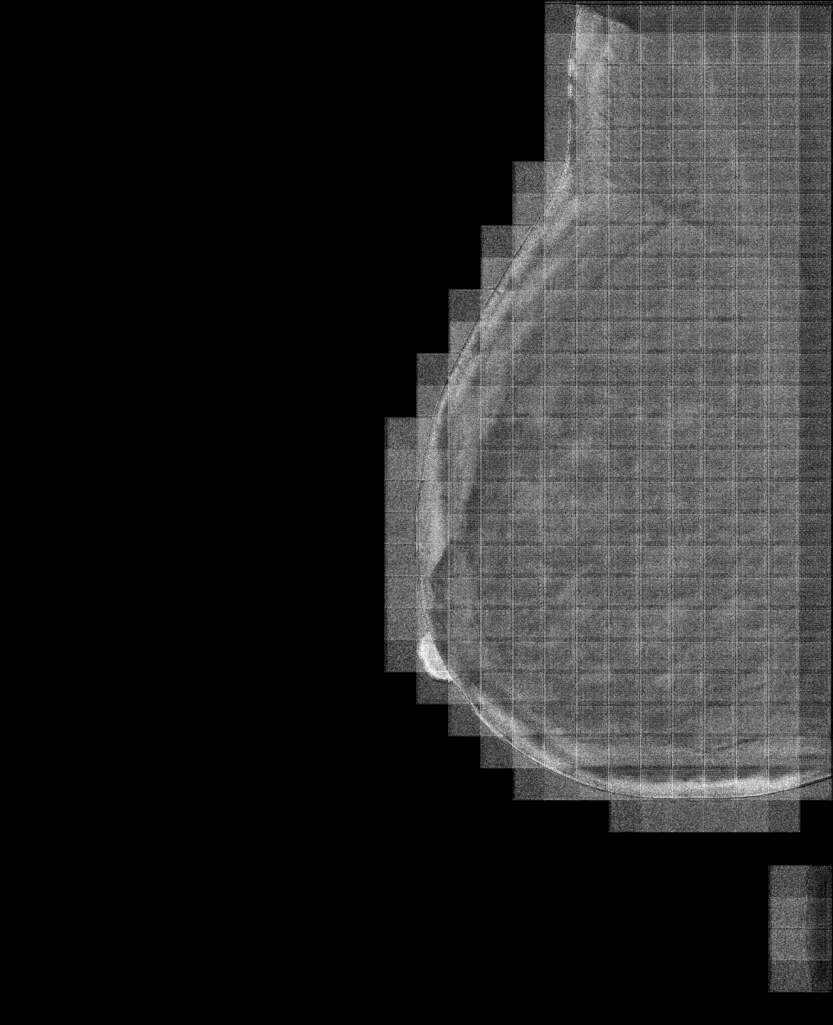

In [59]:
Gray.(result)

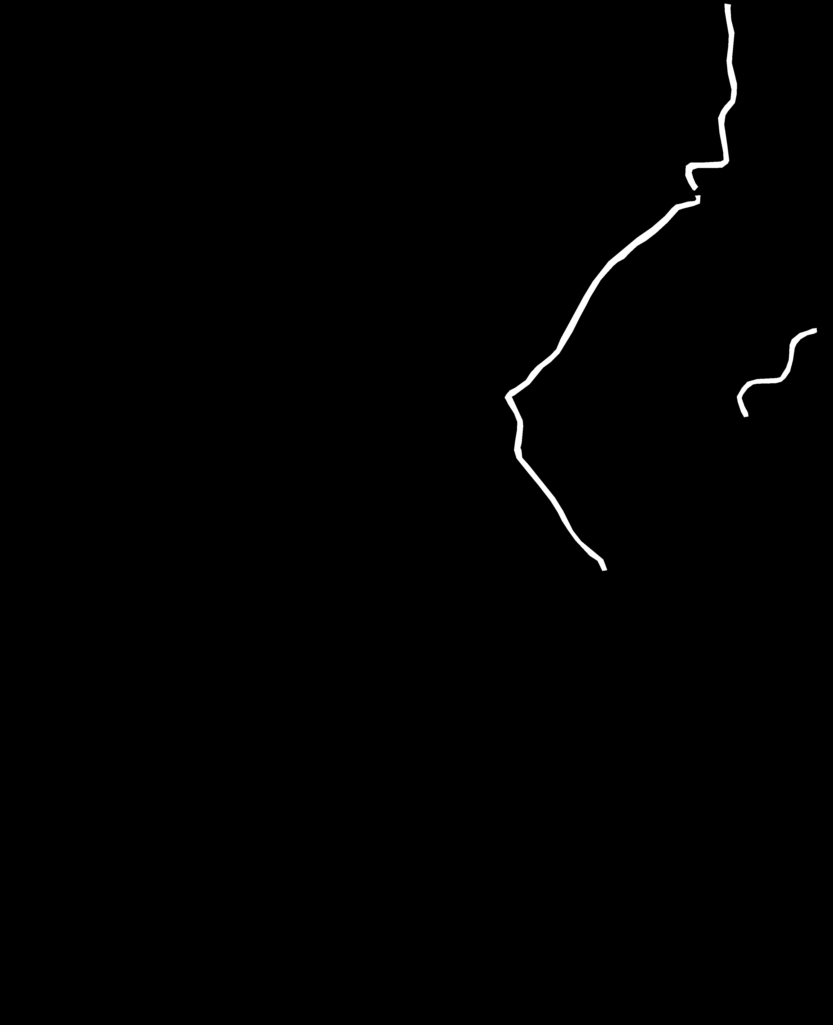

In [49]:
Gray.(temp_y)